In [ ]:
import glob
import pandas as pd
#訓練圖片目錄路徑
document = glob.glob("C:/Users/Big data/Desktop/pic_data/document/*.jpg")
graduation = glob.glob("C:/Users/Big data/Desktop/pic_data/graduation/*.jpg")
live = glob.glob("C:/Users/Big data/Desktop/pic_data/live/*.jpg")
data = pd.DataFrame({
    "path": document+ graduation+ live,
    "ans": [0] * len(document) + [1] * len(graduation)+ [2] * len(live)
})
data

,path,ans
0,C:/Users/Big data/Desktop/pic_data/document\0 ...,0
1,C:/Users/Big data/Desktop/pic_data/document\0 ...,0
2,C:/Users/Big data/Desktop/pic_data/document\0.jpg,0
3,C:/Users/Big data/Desktop/pic_data/document\00...,0
4,C:/Users/Big data/Desktop/pic_data/document\00...,0
...,...,...
794,C:/Users/Big data/Desktop/pic_data/live\782 (2...,2
795,C:/Users/Big data/Desktop/pic_data/live\793 (2...,2
796,C:/Users/Big data/Desktop/pic_data/live\795 (2...,2
797,C:/Users/Big data/Desktop/pic_data/live\798.jpg,2


In [14]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
from keras.layers import Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
# Dense(256, activation="relu") -> 函式(e.g. return print)
# tensor = func(tensor)
for l in vgg.layers:
    l.trainable = False
# 1024:trainable 1024:non-trainable
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(3, activation="softmax")(x)
# Model(inputs=tensor, outputs=tensor)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [18]:
# trainable一定要在compile前就設定
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [19]:
from sklearn.model_selection import train_test_split
# !!! 進入訓練階段以後, list(X), dataframe(X) np.array(O)
import numpy as np
from keras.utils.np_utils import to_categorical
x = np.array(data["path"])
y = np.array(data["ans"])
y_cat = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y_cat, 
                                                    test_size=0.1)

In [20]:
# Pillow(PIL)
# 處理一張照片給你看
from keras.preprocessing.image import load_img
# 一定使用那個模型的preprocess
from keras.applications.vgg16 import preprocess_input
img = load_img(x_train[0], target_size=(224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[ -24.939003  ,   18.221     ,   -9.68      ],
        [ -29.939003  ,   12.221001  ,  -13.68      ],
        [ -27.939003  ,   15.221001  ,  -12.68      ],
        ...,
        [  14.060997  ,   37.221     ,   14.32      ],
        [  15.060997  ,   38.221     ,   15.32      ],
        [  14.060997  ,   36.221     ,   15.32      ]],

       [[ -24.939003  ,   18.221     ,   -9.68      ],
        [ -24.939003  ,   14.221001  ,  -10.68      ],
        [ -28.939003  ,   14.221001  ,  -13.68      ],
        ...,
        [  15.060997  ,   39.221     ,   16.32      ],
        [  14.060997  ,   38.221     ,   15.32      ],
        [  14.060997  ,   37.221     ,   16.32      ]],

       [[ -26.939003  ,   15.221001  ,  -10.68      ],
        [ -26.939003  ,   13.221001  ,  -13.68      ],
        [ -25.939003  ,   12.221001  ,  -14.68      ],
        ...,
        [  14.060997  ,   38.221     ,   15.32      ],
        [  13.060997  ,   36.221     ,   13.32      ],
        [  15.060997  

In [21]:
# x:圖片, y:答案, batch:取幾個
# 回傳 (原始圖片[batch], 處理圖片[batch], 答案[batch])
def get_data(x, y, batch):
    idx = np.random.randint(0, x.shape[0], batch)
    # 原本未處理的圖片
    oriimgs = []
    # Preprocess過後的圖片
    preimgs = []
    for p in x[idx]:
        img = load_img(p, target_size=(224, 224)).convert("RGB")
        img_np = np.array(img)
        oriimgs.append(img_np)
        img_pre = preprocess_input(img_np) 
        preimgs.append(img_pre)

    oriimgs = np.array(oriimgs)
    preimgs = np.array(preimgs)
    ans = y[idx]
    return (oriimgs, preimgs, ans)

In [22]:
# 訓練: train_on_batch
# 驗證: test_on_batch
for i in range(10):
    print("次數:", i + 1)
    batch = 80
    train = get_data(x_train, y_train, batch)
    train_result = cnn.train_on_batch(train[1], train[2])
    print("[Train]:", train_result)
    # 如果可以把驗證的圖片設多一點
    test_batch = 20
    test = get_data(x_test, y_test, test_batch)
    test_result = cnn.test_on_batch(test[1], test[2])
    print("[Validate]:", test_result)
    print("-" * 30)

次數: 1


ValueError: Error when checking target: expected dense_6 to have shape (2,) but got array with shape (3,)

In [ ]:
# 秀一下問題給你看
# 問題1: 怎麼全部同一個預測
# 問題2: 機率不該看到1 & 0
cnn.predict(test[1])

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [3.4438510e-17, 1.0000000e+00],
       [2.4553778e-31, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [5.4243790e-21, 1.0000000e+00],
       [1.0000000e+00, 1.9295128e-17],
       [2.4553778e-31, 1.0000000e+00],
       [7.9162176e-13, 1.0000000e+00],
       [1.0000000e+00, 5.6249081e-35],
       [2.5100299e-17, 1.0000000e+00],
       [1.0000000e+00, 2.1541868e-24],
       [1.0000000e+00, 0.0000000e+00],
       [1.5789500e-38, 1.0000000e+00],
       [2.4553778e-31, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [7.9162176e-13, 1.0000000e+00],
       [3.7497703e-09, 1.0000000e+00],
       [1.0000000e+00, 1.8362955e-37]], dtype=float32)

In [10]:
final_batch = 50
final = get_data(x_test, y_test, final_batch)
pre = cnn.predict(final[1])
cnn.evaluate(final[1], final[2])

20/20 [==============================] - 2s 93ms/step


[2.4177143573760986, 0.8500000238418579]

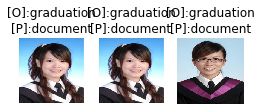

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model沒有predict_classes
# 所以我們要用argmax() 取得最大值的索引
# pre.argmax(axis=1)
idx = np.nonzero(pre.argmax(axis=1) != final[2].argmax(axis=1))[0]
# 預測錯誤的圖片
false_img = final[0][idx]
# 預測錯誤圖片的正確答案
false_answer = final[2].argmax(axis=1)[idx]
# 預測錯誤圖片的預測標籤
false_pre = pre.argmax(axis=1)[idx]

trans = ["document", "graduation", "live"]
width = 10
height = len(false_img) // width + 1
plt.figure(figsize=(14, 8))
for i, img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    t = "[O]:" + trans[false_answer[i]] + "\n[P]:" + trans[false_pre[i]]
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)


In [ ]:
#輸入圖片目錄路徑
TEST = glob.glob("C:/Users/Big data/Desktop/pic_data/test/*.jpg")
inimg = load_img(TEST[0], target_size=(224, 224)).convert("RGB")
img_np2 = np.array(inimg)
img_pre2 = preprocess_input(img_np2)
pre2imgs = []
pre2imgs.append(img_pre2)
pre2imgs = np.array(pre2imgs)
pre2imgs

pre = cnn.predict(pre2imgs)
pre